###### Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license (c) 2019 Daniel Koehn, based on (c)2018 L.A. Barba, G.F. Forsyth [CFD Python](https://github.com/barbagroup/CFDPython#cfd-python), (c)2014 L.A. Barba, I. Hawke, B. Knaepen [Practical Numerical Methods with Python](https://github.com/numerical-mooc/numerical-mooc#practical-numerical-methods-with-python), also under CC-BY.

In [1]:
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, 'r').read())

# 1D Diffusion

We introduced finite-difference methods for partial differential equations (PDEs) in the [second module](https://github.com/daniel-koehn/Differential-equations-earth-system/tree/master/02_finite_difference_intro#numerical-solution-of-differential-equations-introduction-to-the-finite-difference-method), and looked at advection problems in more depth in [module 4](https://github.com/daniel-koehn/Differential-equations-earth-system/tree/master/04_Advection_1D#differential-equations-in-earth-sciences-1d-nonlinear-advection). Now we'll look at solving problems dominated by diffusion.

Why do we separate the discussion of how to solve advection-dominated and diffusion-dominated problems, you might ask? It's all about the harmony between mathematical model and numerical method. Advection and diffusion are inherently different physical processes.

* _Advection_—imagine a surfer on a tall wave, moving fast towards the beach ... advection implies transport, speed, direction. The physics has a directional bias, and we discovered that numerical methods should be compatible with that. That's why we use _upwind_ methods for advection, and we pay attention to problems where waves move in opposite directions, needing special schemes like the _Marker-in-Cell_ approach

* _Diffusion_—now imagine a drop of food dye in a cup of water, slowly spreading in all directions until all the liquid takes a uniform color. [Diffusion](http://en.wikipedia.org/wiki/Diffusion) spreads the concentration of something around (atoms, people, ideas, dirt, anything!). Since it is not a directional process, we need numerical methods that are isotropic (like central differences).

In [2]:
from IPython.display import Image
Image(url='http://upload.wikimedia.org/wikipedia/commons/f/f9/Blausen_0315_Diffusion.png')

In the previous Jupyter notebooks of this series, we studied the numerical solution of the linear and non-linear advection equations using the finite-difference method, and learned about the CFL condition. Now, we will look at the one-dimensional diffusion equation:

$$
\begin{equation}
\frac{\partial u}{\partial t}= \nu \frac{\partial^2 u}{\partial x^2} \tag{1}
\end{equation}
$$

where $\nu$ is a constant known as the *diffusion coefficient*.

The first thing you should notice is that this equation has a second-order derivative. We first need to learn what to do with it!

### Discretizing 2nd-order derivatives

The second-order derivative can be represented geometrically as the line tangent to the curve given by the first derivative.  We will discretize the second-order derivative with a Central Difference scheme: a combination of forward difference and backward difference of the first derivative.  Consider the Taylor expansion of $u_{i+1}$ and $u_{i-1}$ around $u_i$:

$$
u_{i+1} = u_i + \Delta x \frac{\partial u}{\partial x}\big|_i + \frac{\Delta x^2}{2!} \frac{\partial ^2 u}{\partial x^2}\big|_i + \frac{\Delta x^3}{3!} \frac{\partial ^3 u}{\partial x^3}\big|_i + {\mathcal O}(\Delta x^4)
$$

$$
u_{i-1} = u_i - \Delta x \frac{\partial u}{\partial x}\big|_i + \frac{\Delta x^2}{2!} \frac{\partial ^2 u}{\partial x^2}\big|_i - \frac{\Delta x^3}{3!} \frac{\partial ^3 u}{\partial x^3}\big|_i + {\mathcal O}(\Delta x^4)
$$

If we add these two expansions, the odd-numbered derivatives will cancel out.  Neglecting any terms of ${\mathcal O}(\Delta x^4)$ or higher (and really, those are very small), we can rearrange the sum of these two expansions to solve for the second-derivative.  

$$
u_{i+1} + u_{i-1} = 2u_i+\Delta x^2 \frac{\partial ^2 u}{\partial x^2}\big|_i + {\mathcal O}(\Delta x^4)
$$

And finally:

$$
\begin{equation}
\frac{\partial ^2 u}{\partial x^2}=\frac{u_{i+1}-2u_{i}+u_{i-1}}{\Delta x^2} + {\mathcal O}(\Delta x^2)\notag
\end{equation}
$$

The central difference approximation of the 2nd-order derivative is 2nd-order accurate.

### Back to diffusion

We can now write the discretized version of the diffusion equation in 1D:

$$
\begin{equation}
\frac{u_{i}^{n+1}-u_{i}^{n}}{\Delta t}=\nu\frac{u_{i+1}^{n}-2u_{i}^{n}+u_{i-1}^{n}}{\Delta x^2} \notag
\end{equation}
$$

As before, we notice that once we have an initial condition, the only unknown is $u_{i}^{n+1}$, so we re-arrange the equation to isolate this term:

$$
\begin{equation}
u_{i}^{n+1}=u_{i}^{n}+\frac{\nu\Delta t}{\Delta x^2}(u_{i+1}^{n}-2u_{i}^{n}+u_{i-1}^{n}) \notag
\end{equation}
$$

This discrete equation allows us to write a program that advances a solution in time—but we need an initial condition. Let's continue using our favorite: the hat function. So, at $t=0$, $u=2$ in the interval $0.5\le x\le 1$ and $u=1$ everywhere else.

### Stability of the diffusion equation

The diffusion equation is not free of stability constraints. Just like the linear and non-linear advection equations, there are a set of discretization parameters $\Delta x$ and $\Delta t$ that will make the numerical solution blow up. For the diffusion equation and the discretization used here, the stability condition for diffusion is

$$
\begin{equation}
\nu \frac{\Delta t}{\Delta x^2} \leq \frac{1}{2} \notag
\end{equation}
$$

### And solve!

 We are ready for some number-crunching!

The next two code cells initialize the problem by loading the needed libraries, then defining the solution parameters and initial condition. This time, we don't let the user choose just *any* $\Delta t$, though; we have decided this is not safe: people just like to blow things up. Instead, the code calculates a value of $\Delta t$ that will be in the stable range, according to the spatial discretization chosen! You can now experiment with different solution parameters to see how the numerical solution changes, but it won't blow up.

In [3]:
import numpy
from matplotlib import pyplot
%matplotlib inline

In [4]:
# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [5]:
# Set parameters.
nx = 41  # number spatial grid points
L = 2.0  # length of the domain
dx = L / (nx - 1)  # spatial grid size
nu = 0.3  # viscosity
sigma = 0.2  # CFL limit
dt = sigma * dx**2 / nu  # time-step size
nt = 20  # number of time steps to compute

# Get the grid point coordinates.
x = numpy.linspace(0.0, L, num=nx)

# Set the initial conditions.
u0 = numpy.ones(nx)
mask = numpy.where(numpy.logical_and(x >= 0.5, x <= 1.0))
u0[mask] = 2.0

In [6]:
# Integrate in time.
u = u0.copy()

# loop over time steps
for n in range(nt):
    
    un = u.copy() # store old field u
    
    # loop over spatial grid points
    for i in range(1,nx-1):
        u[i] = un[i] + nu * dt / dx**2 * (un[i+1] - 2 * un[i] + un[i-1])

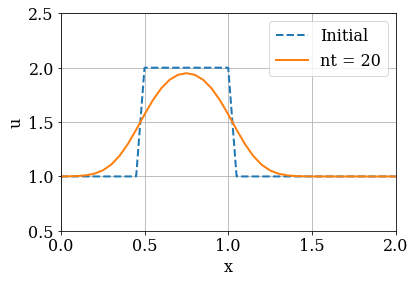

In [7]:
# Plot the solution after nt time steps
# along with the initial conditions.
pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel('x')
pyplot.ylabel('u')
pyplot.grid()
pyplot.plot(x, u0, label='Initial',
            color='C0', linestyle='--', linewidth=2)
pyplot.plot(x, u, label='nt = {}'.format(nt),
            color='C1', linestyle='-', linewidth=2)

pyplot.legend(loc='upper right')
pyplot.xlim(0.0, L)
pyplot.ylim(0.5, 2.5);

## Animations

Looking at before-and-after plots of the wave in motion is helpful, but it's even better if we can see it changing!

We are going to create an animation.
This takes a few steps, but it's actually not hard to do!

First, we define a function, called `diffusion`, that computes and plots the numerical solution of the 1D diffusion equation over the time steps:

In [8]:
def diffusion(u0, sigma=0.5, nt=20):
    """
    Computes the numerical solution of the 1D diffusion equation
    over the time steps.
    
    Parameters
    ----------
    u0 : numpy.ndarray
        The initial conditions as a 1D array of floats.
    sigma : float, optional
        The value of nu * dt / dx^2;
        default: 0.5.
    nt : integer, optional
        The number of time steps to compute;
        default: 20.
    """
    
    # copy initial condition u0 -> u
    u = u0.copy()
    
    # plot initial condition
    fig = pyplot.figure(figsize=(9.0, 6.0))
    pyplot.xlabel('x')
    pyplot.ylabel('u')
    pyplot.grid()
    
    # initial u0
    init = pyplot.plot(x, u0, color='C0', linestyle='-', linewidth=3, label='Initial u0')
    
    # initialize finite-difference solution u
    # Note: comma is needed to update the variable
    line, = pyplot.plot(x, u, color='C1', linestyle='-', linewidth=3, label='FD solution u')
    pyplot.xlim(0.0, L)
    pyplot.ylim(0.5, 2.5)
    pyplot.legend(loc='upper right')
    fig.tight_layout()
    
    # activate interactive plot (will not work in JupyterLab)
    pyplot.ion()    
    pyplot.show(block=False)
    
    # finite difference solution of the 1D diffusion eq.
    # loop over timesteps
    for n in range(nt):
        
        un = u.copy() # store old field u
        
        # loop over spatial grid
        for i in range(1,nx-1):
            u[i] = un[i] + nu * dt / dx**2 * (un[i+1] - 2 * un[i] + un[i-1])

        # update field u 
        line.set_ydata(u)            
        
        # update figure
        fig.canvas.draw()    

We now call the function `diffusion` to compute and animate the history of the solution:

<IPython.core.display.Javascript object>


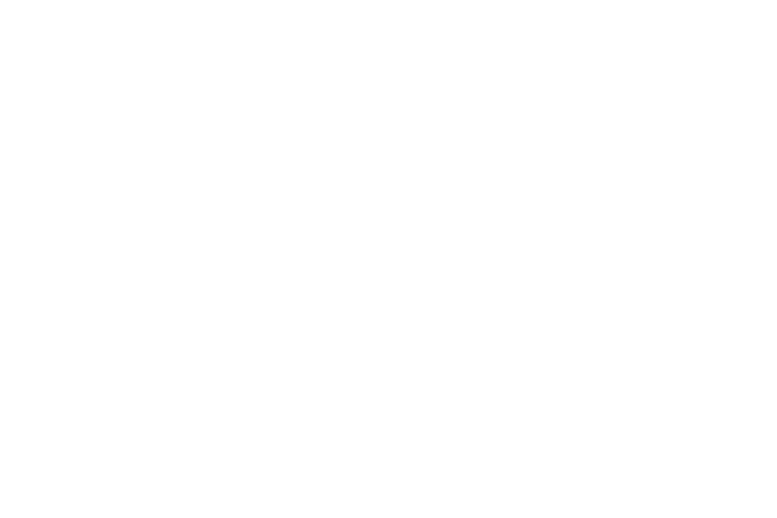

<IPython.core.display.Javascript object>


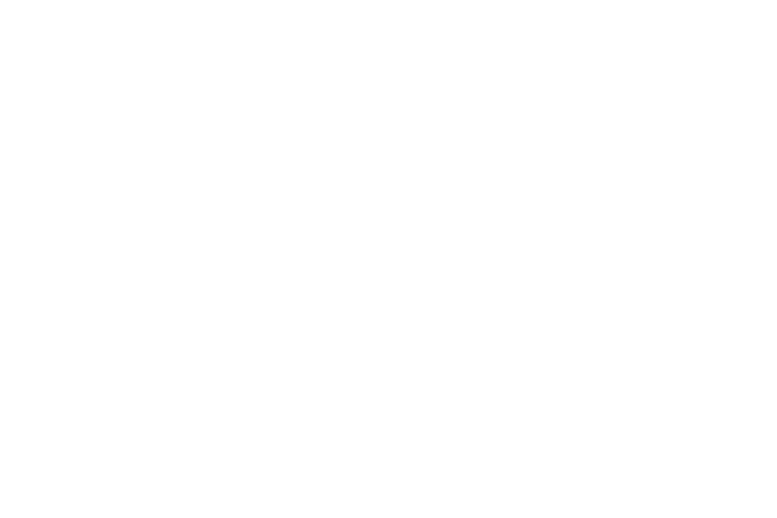

In [9]:
%matplotlib notebook

# Compute the history of the numerical solution.
diffusion(u0, sigma=sigma, nt=500)

## What we learned:

- How to solve the 1D diffusion equation using the FTCS finite difference method

- Animating the time evolution of the 1D diffusion equation solution